In [1]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import feature_importance
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import global_visualize_wo_density

In [2]:
def metric_wrappper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, testnum=10000, noise_sigma=1, rand_seed=0):
    
    np.random.seed(rand_seed)
    x = np.zeros((datanum + testnum, 10))
    for i in range(10):
        x[:, i:i+1] = np.random.uniform(0, 1,[datanum + testnum,1])
    x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = [x[:, [i]] for i in range(10)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
         + 0.1 * np.exp(-8 * x2 + 4)
         + 3 * np.sin(2 * np.pi * x3 * x4)
         + cliff(x5, x6)).reshape([-1,1]) + noise_sigma*np.random.normal(0, 1, [datanum + testnum, 1])

    task_type = "Regression"
    meta_info = {"X1":{"type":"continuous"},
             "X2":{"type":"continuous"},
             "X3":{"type":"continuous"},
             "X4":{"type":"continuous"},
             "X5":{"type":"continuous"},
             "X6":{"type":"continuous"},
             "X7":{"type":"continuous"},
             "X8":{"type":"continuous"},
             "X9":{"type":"continuous"},
             "X10":{"type":"continuous"},
             "Y":{"type":"target"}}
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == "target":
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]["scaler"] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]["scaler"] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=testnum, random_state=rand_seed)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrappper(rmse, sy)

train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=10000, testnum=10000, noise_sigma=1, rand_seed=0)

In [3]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

gaminet = GAMINet(meta_info=meta_info, interact_num=10, interact_arch=[20, 10],
               subnet_arch=[10, 6], task_type=task_type, activation_func=tf.tanh, main_grid_size=101, interact_grid_size=51,
               batch_size=min(500, int(0.2*train_x.shape[0])),
               lr_bp=0.001, main_threshold=0.05, total_threshold=0.05,
               init_training_epochs=2000, interact_training_epochs=2000, tuning_epochs=10,
               verbose=True, val_ratio=0.2, early_stop_thres=10, random_state=0)
gaminet.fit(train_x, train_y)

val_x = train_x[gaminet.val_idx, :]
val_y = train_y[gaminet.val_idx, :]
tr_x = train_x[gaminet.tr_idx, :]
tr_y = train_y[gaminet.tr_idx, :]
pred_train = gaminet.predict(tr_x)
pred_val = gaminet.predict(val_x)
pred_test = gaminet.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                      np.round(get_metric(val_y, pred_val),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

Main Effects Training.


W1122 16:45:56.658074 139678280664896 deprecation.py:323] From /home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/tensorflow_core/python/autograph/impl/api.py:330: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


Main effects training epoch: 1, train loss: 0.14202, val loss: 0.14795
Main effects training epoch: 2, train loss: 0.12700, val loss: 0.13402
Main effects training epoch: 3, train loss: 0.11545, val loss: 0.12228
Main effects training epoch: 4, train loss: 0.10544, val loss: 0.11173
Main effects training epoch: 5, train loss: 0.09656, val loss: 0.10246
Main effects training epoch: 6, train loss: 0.08841, val loss: 0.09402
Main effects training epoch: 7, train loss: 0.08093, val loss: 0.08633
Main effects training epoch: 8, train loss: 0.07402, val loss: 0.07926
Main effects training epoch: 9, train loss: 0.06765, val loss: 0.07263
Main effects training epoch: 10, train loss: 0.06182, val loss: 0.06661
Main effects training epoch: 11, train loss: 0.05649, val loss: 0.06111
Main effects training epoch: 12, train loss: 0.05161, val loss: 0.05593
Main effects training epoch: 13, train loss: 0.04717, val loss: 0.05133
Main effects training epoch: 14, train loss: 0.04314, val loss: 0.04716
M

Main effects training epoch: 116, train loss: 0.01050, val loss: 0.01126
Main effects training epoch: 117, train loss: 0.01050, val loss: 0.01125
Main effects training epoch: 118, train loss: 0.01050, val loss: 0.01126
Main effects training epoch: 119, train loss: 0.01050, val loss: 0.01124
Main effects training epoch: 120, train loss: 0.01049, val loss: 0.01125
Main effects training epoch: 121, train loss: 0.01051, val loss: 0.01126
Main effects training epoch: 122, train loss: 0.01050, val loss: 0.01126
Main effects training epoch: 123, train loss: 0.01051, val loss: 0.01123
Main effects training epoch: 124, train loss: 0.01050, val loss: 0.01126
Main effects training epoch: 125, train loss: 0.01049, val loss: 0.01124
Main effects training epoch: 126, train loss: 0.01051, val loss: 0.01125
Main effects training epoch: 127, train loss: 0.01049, val loss: 0.01125
Main effects training epoch: 128, train loss: 0.01049, val loss: 0.01126
Main effects training epoch: 129, train loss: 0.010

Main effects training epoch: 230, train loss: 0.00994, val loss: 0.01074
Main effects training epoch: 231, train loss: 0.00994, val loss: 0.01072
Main effects training epoch: 232, train loss: 0.00995, val loss: 0.01079
Main effects training epoch: 233, train loss: 0.00992, val loss: 0.01073
Main effects training epoch: 234, train loss: 0.00993, val loss: 0.01073
Main effects training epoch: 235, train loss: 0.00993, val loss: 0.01073
Main effects training epoch: 236, train loss: 0.00990, val loss: 0.01073
Main effects training epoch: 237, train loss: 0.00990, val loss: 0.01065
Main effects training epoch: 238, train loss: 0.00988, val loss: 0.01070
Main effects training epoch: 239, train loss: 0.00988, val loss: 0.01064
Main effects training epoch: 240, train loss: 0.00988, val loss: 0.01069
Main effects training epoch: 241, train loss: 0.00989, val loss: 0.01073
Main effects training epoch: 242, train loss: 0.00986, val loss: 0.01068
Main effects training epoch: 243, train loss: 0.009

Interaction training epoch: 57, train loss: 0.00499, val loss: 0.00522
Interaction training epoch: 58, train loss: 0.00500, val loss: 0.00523
Interaction training epoch: 59, train loss: 0.00497, val loss: 0.00521
Interaction training epoch: 60, train loss: 0.00498, val loss: 0.00521
Interaction training epoch: 61, train loss: 0.00494, val loss: 0.00515
Interaction training epoch: 62, train loss: 0.00494, val loss: 0.00518
Interaction training epoch: 63, train loss: 0.00492, val loss: 0.00516
Interaction training epoch: 64, train loss: 0.00488, val loss: 0.00512
Interaction training epoch: 65, train loss: 0.00487, val loss: 0.00512
Interaction training epoch: 66, train loss: 0.00484, val loss: 0.00507
Interaction training epoch: 67, train loss: 0.00484, val loss: 0.00506
Interaction training epoch: 68, train loss: 0.00480, val loss: 0.00504
Interaction training epoch: 69, train loss: 0.00476, val loss: 0.00500
Interaction training epoch: 70, train loss: 0.00471, val loss: 0.00494
Intera

Interaction training epoch: 173, train loss: 0.00364, val loss: 0.00378
Interaction training epoch: 174, train loss: 0.00363, val loss: 0.00376
Interaction training epoch: 175, train loss: 0.00364, val loss: 0.00378
Interaction training epoch: 176, train loss: 0.00363, val loss: 0.00378
Interaction training epoch: 177, train loss: 0.00363, val loss: 0.00379
Interaction training epoch: 178, train loss: 0.00362, val loss: 0.00377
Interaction training epoch: 179, train loss: 0.00362, val loss: 0.00376
Interaction training epoch: 180, train loss: 0.00362, val loss: 0.00378
Interaction training epoch: 181, train loss: 0.00364, val loss: 0.00379
Interaction training epoch: 182, train loss: 0.00362, val loss: 0.00376
Interaction training epoch: 183, train loss: 0.00360, val loss: 0.00375
Interaction training epoch: 184, train loss: 0.00359, val loss: 0.00374
Interaction training epoch: 185, train loss: 0.00359, val loss: 0.00373
Interaction training epoch: 186, train loss: 0.00358, val loss: 

Interaction training epoch: 287, train loss: 0.00281, val loss: 0.00292
Interaction training epoch: 288, train loss: 0.00282, val loss: 0.00295
Interaction training epoch: 289, train loss: 0.00280, val loss: 0.00292
Interaction training epoch: 290, train loss: 0.00280, val loss: 0.00289
Interaction training epoch: 291, train loss: 0.00280, val loss: 0.00291
Interaction training epoch: 292, train loss: 0.00279, val loss: 0.00290
Interaction training epoch: 293, train loss: 0.00283, val loss: 0.00293
Interaction training epoch: 294, train loss: 0.00282, val loss: 0.00292
Interaction training epoch: 295, train loss: 0.00281, val loss: 0.00289
Interaction training epoch: 296, train loss: 0.00278, val loss: 0.00288
Interaction training epoch: 297, train loss: 0.00278, val loss: 0.00290
Interaction training epoch: 298, train loss: 0.00278, val loss: 0.00289
Interaction training epoch: 299, train loss: 0.00277, val loss: 0.00286
Interaction training epoch: 300, train loss: 0.00277, val loss: 

Interaction training epoch: 401, train loss: 0.00244, val loss: 0.00251
Interaction training epoch: 402, train loss: 0.00244, val loss: 0.00250
Interaction training epoch: 403, train loss: 0.00244, val loss: 0.00250
Interaction training epoch: 404, train loss: 0.00244, val loss: 0.00250
Interaction training epoch: 405, train loss: 0.00245, val loss: 0.00249
Interaction training epoch: 406, train loss: 0.00244, val loss: 0.00250
Interaction training epoch: 407, train loss: 0.00244, val loss: 0.00247
Interaction training epoch: 408, train loss: 0.00243, val loss: 0.00249
Interaction training epoch: 409, train loss: 0.00242, val loss: 0.00246
Interaction training epoch: 410, train loss: 0.00243, val loss: 0.00250
Interaction training epoch: 411, train loss: 0.00242, val loss: 0.00247
Interaction training epoch: 412, train loss: 0.00243, val loss: 0.00247
Interaction training epoch: 413, train loss: 0.00244, val loss: 0.00249
Interaction training epoch: 414, train loss: 0.00241, val loss: 

In [4]:
data_dict = gaminet.global_explain(save_dict=False, folder=simu_dir, name='demo_gaminet_simu1_global')

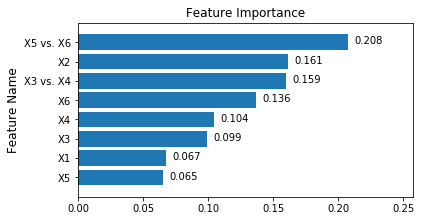

In [5]:
feature_importance(data_dict)

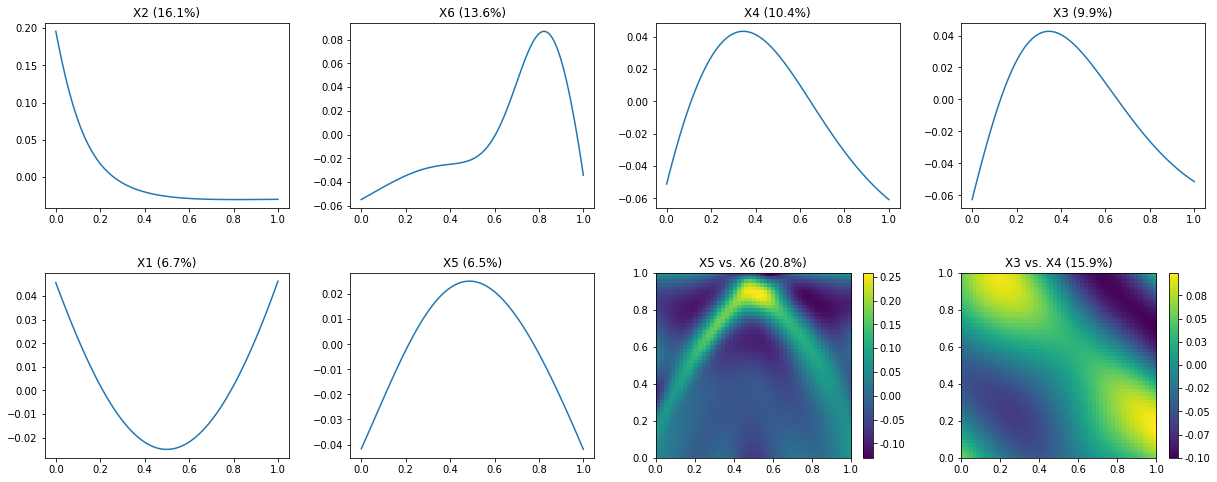

In [6]:
global_visualize_wo_density(data_dict)

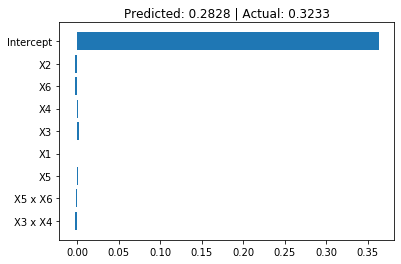

In [7]:
data_dict = gaminet.local_explain(train_x[[0]], train_y[[0]], save_dict=False, folder=simu_dir, name='demo_gaminet_simu1_local')
local_visualize(data_dict)